# Sentence Construction Model Evaluation

This notebook compares different models for generating grammatically correct English sentences from ASL-style input word sequences. We evaluate:

- A fine-tuned **T5 transformer model**
- A **simple rule-based baseline**

Evaluation is based on BLEU score accuracy against ground truth sentences.


In [10]:
import pandas as pd

# Load expanded 
df = pd.read_csv("Sentence_Construction_Dataset.csv")  
df.head()

,input_words,target_sentence
0,"['i', 'want', 'apple']",I want an apple.
1,"['mom', 'say', 'no']",Mom says no.
2,"['dog', 'sleep', 'bed']",A dog sleeping on a bed.
3,"['thankyou', 'mom']","Thank you, mom."
4,"['go', 'outside', 'play']",Let's go outside to play.


In [11]:
from transformers import pipeline

# Load T5 model
t5 = pipeline("text2text-generation", model="mrm8488/t5-base-finetuned-common_gen")

def t5_generate(words):
    prompt = " ".join(words)
    result = t5(prompt, max_new_tokens=30, num_beams=4, clean_up_tokenization_spaces=True)
    sentence = result[0]['generated_text'].strip()

    # Format sentence
    sentence = sentence[0].upper() + sentence[1:]
    if not sentence.endswith((".", "!", "?")):
        sentence += "."
    return sentence


Device set to use cpu


In [12]:
def rule_based_generate(words):
    if not words:
        return ""
    sentence = " ".join(words).capitalize()
    if not sentence.endswith("."):
        sentence += "."
    return sentence

In [13]:
from transformers import pipeline

gpt2 = pipeline("text-generation", model="distilgpt2")  # or "gpt2"

def gpt2_generate(words):
    prompt = " ".join(words)
    result = gpt2(prompt, max_length=30, num_return_sequences=1)
    sentence = result[0]['generated_text'].strip()
    
    # Cut off trailing weird continuations (you can improve this)
    sentence = sentence.split(".")[0] + "."
    return sentence[0].upper() + sentence[1:] if sentence else ""


Device set to use cpu


In [14]:
bart = pipeline("text2text-generation", model="facebook/bart-large-cnn")

def bart_generate(words):
    prompt = " ".join(words)
    result = bart(prompt, max_length=30, num_beams=4, clean_up_tokenization_spaces=True)
    sentence = result[0]['generated_text'].strip()
    return sentence[0].upper() + sentence[1:] + ("" if sentence.endswith(".") else ".")


Device set to use cpu


In [15]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

smoothie = SmoothingFunction().method4

t5_bleus = []
rule_bleus = []
gpt2_bleus = []
bart_bleus = []

for _, row in df.iterrows():
    words = eval(row['input_words']) if isinstance(row['input_words'], str) else row['input_words']
    target = row['target_sentence']

    # Generate predictions
    t5_sent = t5_generate(words)
    rule_sent = rule_based_generate(words)
    gpt2_sent = gpt2_generate(words)
    bart_sent = bart_generate(words)

    # BLEU scores
    t5_bleus.append(sentence_bleu([target.split()], t5_sent.split(), smoothing_function=smoothie))
    rule_bleus.append(sentence_bleu([target.split()], rule_sent.split(), smoothing_function=smoothie))
    gpt2_bleus.append(sentence_bleu([target.split()], gpt2_sent.split(), smoothing_function=smoothie))
    bart_bleus.append(sentence_bleu([target.split()], bart_sent.split(), smoothing_function=smoothie))


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=30) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
c:\Users\ngnic\OneDrive\Documents\school\year 3\ASL-translation\venv310\lib\site-packages\transformers\generation\utils.py:1633: UserWarning: Unfeasible length constraints: `min_length` (56) is larger than the maximum possible length (30). Generation will stop at the defined maximum length. You should dec

In [25]:
import numpy as np

print(f"Average BLEU score (T5):        {np.mean(t5_bleus):.4f}")
print(f"Average BLEU score (Rule-based): {np.mean(rule_bleus):.4f}")
print(f"Average BLEU score (GPT-2):       {np.mean(gpt2_bleus):.4f}")
print(f"Average BLEU score (BART):        {np.mean(bart_bleus):.4f}")


Average BLEU score (T5):        0.6471
Average BLEU score (Rule-based): 0.0422
Average BLEU score (GPT-2):       0.0221
Average BLEU score (BART):        0.0207


In [12]:
for i in range(6):
    words = eval(df.iloc[i]['input_words']) if isinstance(df.iloc[i]['input_words'], str) else df.iloc[i]['input_words']
    print("Input Words:", words)
    print("Target:", df.iloc[i]['target_sentence'])
    print("T5 Output:", t5_generate(words))
    print("Rule Output:", rule_based_generate(words))
    print("-" * 50)


Input Words: ['grandma', 'bake', 'cake']
Target: A grandma is baking a cake.
T5 Output: A grandma is baking a cake.
Rule Output: Grandma bake cake.
--------------------------------------------------
Input Words: ['cat', 'jump', 'table']
Target: The cat jumped on the table.
T5 Output: A cat is jumping on a table.
Rule Output: Cat jump table.
--------------------------------------------------
Input Words: ['dog', 'bark', 'loud']
Target: A dog is barking loudly.
T5 Output: A dog is barking loudly.
Rule Output: Dog bark loud.
--------------------------------------------------
Input Words: ['girl', 'clap', 'happy']
Target: The girl is clapping because she is happy.
T5 Output: A girl is clapping and happy.
Rule Output: Girl clap happy.
--------------------------------------------------
Input Words: ['boy', 'run', 'grass']
Target: A boy is running on the grass.
T5 Output: A boy is running on the grass.
Rule Output: Boy run grass.
--------------------------------------------------
Input Words:

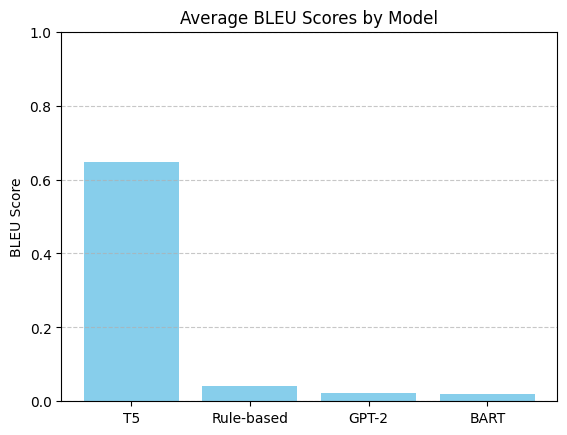

In [26]:
import matplotlib.pyplot as plt

model_names = ['T5', 'Rule-based', 'GPT-2', 'BART']
bleu_means = [np.mean(t5_bleus), np.mean(rule_bleus), np.mean(gpt2_bleus), np.mean(bart_bleus)]

plt.bar(model_names, bleu_means, color='skyblue')
plt.title("Average BLEU Scores by Model")
plt.ylabel("BLEU Score")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

# Load model
embedder = SentenceTransformer("paraphrase-MiniLM-L6-v2")

# Ground truth and predictions
y_true = []
y_pred_t5 = []
y_pred_rule = []
y_pred_gpt2 = []
y_pred_bart = []

THRESHOLD = 0.9

for _, row in df.iterrows():
    words = eval(row['input_words']) if isinstance(row['input_words'], str) else row['input_words']
    target = row['target_sentence'].strip()
    target_emb = embedder.encode(target, convert_to_tensor=True)

    def is_match(gen):
        gen_emb = embedder.encode(gen.strip(), convert_to_tensor=True)
        sim = util.cos_sim(target_emb, gen_emb).item()
        return 1 if sim >= THRESHOLD else 0

    y_true.append(1)

    y_pred_t5.append(is_match(t5_generate(words)))
    y_pred_rule.append(is_match(rule_based_generate(words)))
    y_pred_gpt2.append(is_match(gpt2_generate(words)))
    y_pred_bart.append(is_match(bart_generate(words)))

# Metric Summary Table
def get_metrics(preds):
    return {
        "Precision": precision_score(y_true, preds),
        "Recall": recall_score(y_true, preds),
        "F1 Score": f1_score(y_true, preds),
    }

results = {
    "T5": get_metrics(y_pred_t5),
    "Rule-based": get_metrics(y_pred_rule),
    "GPT-2": get_metrics(y_pred_gpt2),
    "BART": get_metrics(y_pred_bart),
}

df_metrics = pd.DataFrame(results).T.reset_index().rename(columns={"index": "Model"})
print(df_metrics)


# Confusion Matrix Plotting
def show_confusion(preds, name):
    cm = confusion_matrix(y_true, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Wrong", "Correct"])
    disp.plot(cmap="Blues")
    plt.title(f"{name} Confusion Matrix (Threshold ≥ {THRESHOLD})")
    plt.show()

show_confusion(y_pred_t5, "T5")
show_confusion(y_pred_rule, "Rule-based")
show_confusion(y_pred_gpt2, "GPT-2")
show_confusion(y_pred_bart, "BART")


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=30) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
c:\Users\ngnic\OneDrive\Documents\school\year 3\ASL-translation\venv310\lib\site-packages\transformers\generation\utils.py:1633: UserWarning: Unfeasible length constraints: `min_length` (56) is larger than the maximum possible length (30). Generation will stop at the defined maximum length. You should decrease the minimum length and/or increase the maximum length.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=30) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main

,Model,Precision,Recall,F1 Score
0,T5,1.0,0.68,0.809524
1,Rule-based,1.0,0.56,0.717949
2,GPT-2,1.0,0.15,0.260870
3,BART,0.0,0.00,0.000000
